In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
x = np.linspace(0,50,501)
y = np.sin(x)

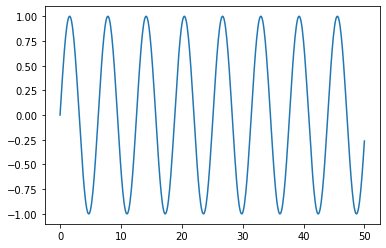

In [3]:
plt.plot(x,y)

In [4]:
df = pd.DataFrame(data=y,index=x,columns=["sine"])
df.head()

,sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418


In [5]:
test_per = 0.1

In [6]:
test_point = np.round(len(df)*test_per)

In [7]:
test_ind = int(len(df)-test_point)

In [8]:
test_ind

451

In [55]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [56]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [57]:
sc.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [58]:
scaled_train = sc.transform(train)
scaled_test = sc.transform(test)

In [59]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
TimeseriesGenerator?

In [60]:
length = 50
batch_size = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=batch_size)

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM

In [62]:
n_features = 1
model = Sequential()
model.add(SimpleRNN(50,input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer="adam",loss="mse")

In [63]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 50)                2600      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [64]:
model.fit_generator(generator,epochs=5)

Epoch 1/5
401/401 [==============================] - 12s 31ms/step - loss: 0.0026
Epoch 2/5
401/401 [==============================] - 13s 31ms/step - loss: 1.1600e-04
Epoch 3/5
401/401 [==============================] - 12s 31ms/step - loss: 6.7344e-05
Epoch 4/5
401/401 [==============================] - 12s 31ms/step - loss: 7.4770e-05
Epoch 5/5
401/401 [==============================] - 13s 31ms/step - loss: 2.8961e-04


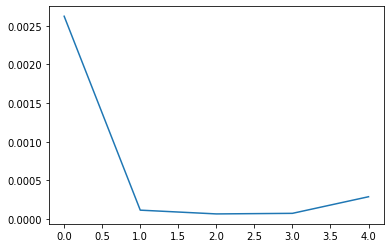

In [65]:
losses = pd.DataFrame(model.history.history)
plt.plot(losses)

In [66]:
first_eval_batch = scaled_train[-length:]
first_eval_batch = first_eval_batch.reshape(1,length,n_features)
model.predict(first_eval_batch)

array([[0.9494035]], dtype=float32)

In [67]:
scaled_test[0]

array([0.94955134])

In [68]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch  = first_eval_batch.reshape(1,length,n_features)

for i in range(len(test)):
  curr_pred = model.predict(current_batch)[0]
  test_predictions.append(curr_pred)
  current_batch = np.append(current_batch[:,1:,:],[[curr_pred]],axis=1)

In [69]:
true_preds = sc.inverse_transform(test_predictions)

In [70]:
test["predictions"] = true_preds

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


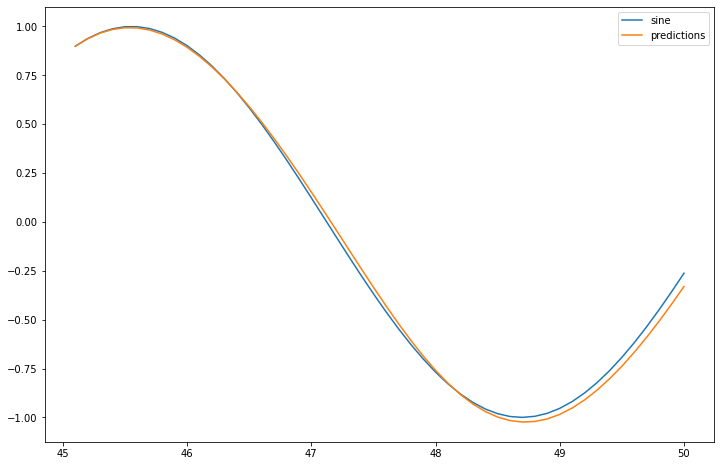

In [71]:
test.plot(figsize=(12,8))

In [72]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss",patience=2)

In [73]:
valid_len = 49
generator = TimeseriesGenerator(scaled_train,scaled_train,valid_len,batch_size=batch_size)
validation_gen = TimeseriesGenerator(scaled_test,scaled_test,valid_len,batch_size=batch_size)

In [74]:
model = Sequential()
model.add(LSTM(50,input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer="adam",loss="mse")

In [75]:
model.fit_generator(generator,validation_data=validation_gen,callbacks=[early_stop],epochs=20)

Epoch 1/20
402/402 [==============================] - 2s 5ms/step - loss: 0.0129 - val_loss: 8.0907e-05
Epoch 2/20
402/402 [==============================] - 2s 4ms/step - loss: 3.7869e-04 - val_loss: 1.6157e-06
Epoch 3/20
402/402 [==============================] - 2s 4ms/step - loss: 4.9901e-05 - val_loss: 4.5743e-06
Epoch 4/20
402/402 [==============================] - 2s 4ms/step - loss: 4.8873e-05 - val_loss: 6.5381e-05


In [76]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch  = first_eval_batch.reshape(1,length,n_features)

for i in range(len(test)):
  curr_pred = model.predict(current_batch)[0]
  test_predictions.append(curr_pred)
  current_batch = np.append(current_batch[:,1:,:],[[curr_pred]],axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


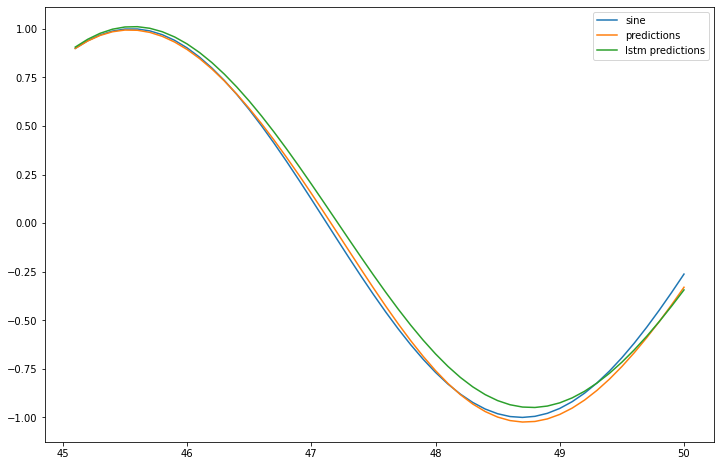

In [77]:
true_preds = sc.inverse_transform(test_predictions)
test["lstm predictions"] = true_preds
test.plot(figsize=(12,8))

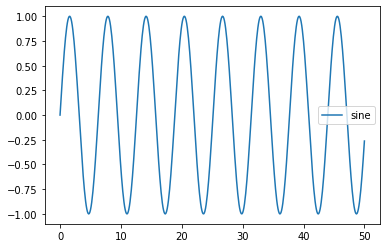

In [78]:
df.plot()

In [79]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [80]:
generator = TimeseriesGenerator(scaled_full_data,scaled_full_data,valid_len,batch_size=batch_size)

In [81]:
model = Sequential()
model.add(LSTM(50,input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer="adam",loss="mse")

In [82]:
model.fit_generator(generator,epochs=6)

Epoch 1/6
452/452 [==============================] - 2s 4ms/step - loss: 0.0111
Epoch 2/6
452/452 [==============================] - 2s 4ms/step - loss: 8.6030e-05
Epoch 3/6
452/452 [==============================] - 2s 4ms/step - loss: 6.6655e-05
Epoch 4/6
452/452 [==============================] - 2s 4ms/step - loss: 9.5987e-05
Epoch 5/6
452/452 [==============================] - 2s 4ms/step - loss: 5.4881e-04
Epoch 6/6
452/452 [==============================] - 2s 4ms/step - loss: 4.4650e-05


In [83]:
forecast = []
length = valid_len
first_eval_batch = scaled_full_data[-length:]
current_batch  = first_eval_batch.reshape(1,length,n_features)

for i in range(25):
  curr_pred = model.predict(current_batch)[0]
  forecast.append(curr_pred)
  current_batch = np.append(current_batch[:,1:,:],[[curr_pred]],axis=1)

In [85]:
forecast = sc.inverse_transform(forecast)

In [86]:
forecast_index = np.arange(50.1,52.6,0.1)

In [87]:
len(forecast_index)

25

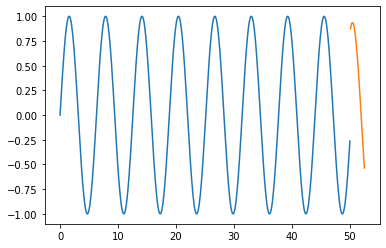

In [90]:
plt.plot(df.index,df.sine)
plt.plot(forecast_index,forecast)

In [91]:
forecast[0]

array([0.8733728])

In [92]:
df.iloc[-1]

sine   -0.262375
Name: 50.0, dtype: float64